# FasterRCNN Prediction Object

In [3]:
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

### Data

For example, let's pick the first image from Hamburg from CityScapes dataset. I saved it to data directory:

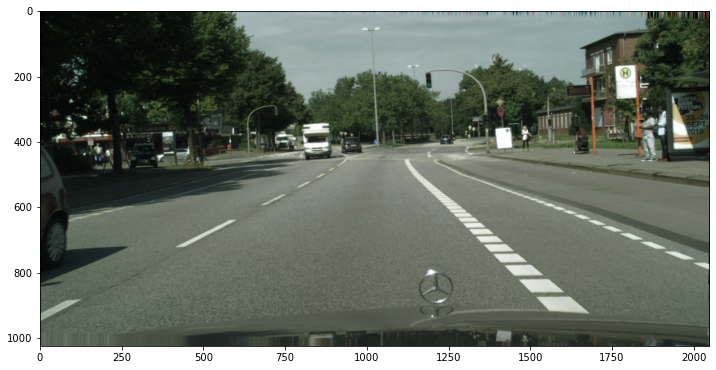

In [2]:
img_name = 'hamburg_000000_000042_leftImg8bit'

img = Image.open('../data/' + img_name + '.png')
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
ax.imshow(img);

### Ground truth

And check the ground truth annotations from CityPersons dataset:

In [4]:
with open('../data/ground-truth-annotations-0.pickle', 'rb') as fp:
    gt0 = pickle.load(fp)

In `gt0` we saved the ground truth bounding boxes:

In [6]:
gt0

[array([682, 401,  13,  33], dtype=uint16),
 array([202, 418,  20,  50], dtype=uint16),
 array([166, 403,  30,  71], dtype=uint16),
 array([1343,  369,    6,   15], dtype=uint16),
 array([1637,  352,   30,   73], dtype=uint16),
 array([1826,  308,   62,  150], dtype=uint16),
 array([1867,  291,   69,  168], dtype=uint16),
 array([1469,  352,   31,   76], dtype=uint16)]

Modified function to get the data as a json

In [6]:
import json
import scipy.io
from datetime import date

def data_as_json(gt0):

    inf = {"year": 2021,
           "version": 1,
            "describtion": "Data for object detection",
            "contributor": "ML-group",
            "url": "test", #leave all urls empty?
            "date_created": str(date.today())}
    

    #can we leave licences like this?
    lic = [{"id": 1,
            "name": "test",
            "url": "test"}]
    

    cat = [{"id": 1,
            "name": "pedestrian",
            "supercategory": "person"}]

    im = []
    ann = []

    one_im = {"id": 1, 
           "width": 2000, #do we have the same height/width and if not where is this information
           "height": 1000,
           "file_name": "image1",
           "license": 1,
           "flickr_url": "test",
           "coco_url": "test",
           "date_captured": "test"} #probably also irrelevant

    im.append(one_im)

    for i in range(0,np.shape(gt0)[0]):
        bb = gt0[i]
        one_ann = {"id": i,
                    "image_id": 1,  #same as above
                    "category_id": 1,
                    "area": int(bb[2] * bb[3]),
                    "bbox": [int(bb[0]), int(bb[1]), int(bb[2]), int(bb[3])],
                    "iscrowd":0} #should probably be 0 for all instances
        ann.append(one_ann)
    
    data = {"info": inf, "licenses": lic, "images": im, "annotations": ann, "categories": cat}
    f = open("../data/gt0.json","w")
    f. write(json.dumps(data))

In [8]:
data_as_json(gt0)

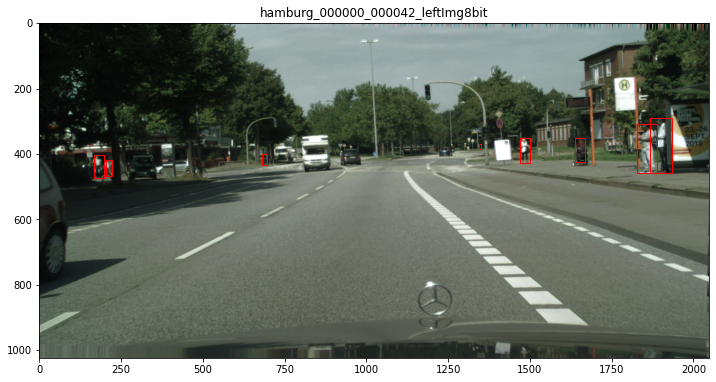

In [14]:
plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots()
ax.imshow(img);

# bbox = [x, y, w, h]
for bbox in gt0:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.title(img_name)
plt.show()

### Prediction from FasterRCNN

I saved the prediction:

```python
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
```

To `data` directory, which we can load:

In [4]:
with open('../data/prediction-0.pickle', 'rb') as fp:
    prediction = pickle.load(fp)

In [10]:
type(prediction)

dict

In [18]:
preds = prediction['boxes']  # predicted bboxes
preds = preds.cpu().data.numpy()  # to numpy array
preds[0]

array([1867.6996 ,  290.07065, 1935.4948 ,  457.90457], dtype=float32)

Modified function to get the results as a json

In [7]:
def results_as_json(prediction):
    infos = []
    preds = prediction['boxes']  # predicted bboxes
    preds = preds.cpu().data.numpy()  # to numpy array
    scores = prediction['scores']  # scores of predicted bboxes
    scores = scores.cpu().data.numpy()
    for i in range(0, len(scores)):
        if scores[i]<0.3:
            continue
            
        info = {"image_id": 1, #this idx should be the same as the one in the data
                "category_id": 1,
                "bbox": [int(preds[i][0]), int(preds[i][1]), int(preds[i][2]-preds[i][0]), int(preds[i][3]-preds[i][1])],
                "score": float(scores[i])}
        infos.append(info)

    f = open("../data/det0.json","w")
    f. write(json.dumps(infos))

In [9]:
results_as_json(prediction)

In [18]:
prediction

{'boxes': tensor([[1867.6996,  290.0706, 1935.4948,  457.9046],
         [1825.1581,  304.0287, 1889.9994,  457.7863],
         [1470.5577,  350.1487, 1499.6713,  426.3264],
         [ 164.0272,  403.8603,  191.3489,  474.3809],
         [1633.3987,  347.1248, 1670.2074,  433.6295],
         [ 203.7215,  418.0811,  224.0584,  467.4494],
         [ 692.3051,  399.4909,  705.6819,  431.1591],
         [ 718.3954,  396.5953,  730.8055,  428.0432],
         [ 469.8653,  405.0747,  493.8742,  465.2343],
         [ 688.6938,  401.5743,  699.9677,  431.3632],
         [ 699.0222,  400.2999,  708.7267,  429.4056],
         [ 196.3171,  421.6237,  217.0280,  470.3988],
         [ 682.9064,  397.6649,  696.6857,  431.2079],
         [ 265.0278,  426.7236,  281.0891,  464.4976],
         [ 244.1873,  420.7523,  260.9995,  462.7815],
         [ 723.4791,  400.8794,  733.6397,  427.0487],
         [1020.6530,  389.3322, 1031.0763,  414.2762],
         [ 715.3606,  399.4365,  726.7148,  428.1268],
 

We can translate it to numpy arrays:

In [19]:
preds = prediction['boxes'] # predicted bboxes
preds = preds.cpu().data.numpy() # to numpy array

scores = prediction['scores'] # scores of predicted bboxes
scores = scores.cpu().data.numpy()

Say, we keep only bboxes where score > threshold:

In [23]:
threshold = .3
highs = list(np.where(scores > threshold)[0])
bboxes_x0x1y0y1 = []
for high in highs:
    bboxes_x0x1y0y1.append(list(preds[high]))

And transform back to [x, y, w, h] format:

In [24]:
bboxes = []
for bbox in bboxes_x0x1y0y1:
    bbox = list(bbox)
    x0, y0 = bbox[0], bbox[1]
    x1, y1 = bbox[2], bbox[3]

    bboxes.append([x0, y0, x1 - x0, y1 - y0])

Draw the predicted bounding boxes:

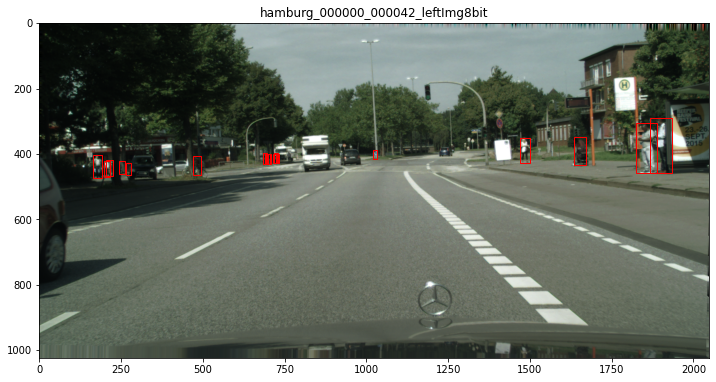

In [25]:
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
ax.imshow(img);

# bbox = [x, y, w, h]
for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.title(img_name)
plt.show()

### Evaluation

TODO: 
If possible, using ground truth bounding boxes `gt0` object and predicted bounding boxes `bboxes` and COCO tools to calculate MR measure for this example. Goal is to then run the same on all predictions for the test set and put our model on (this)[https://github.com/cvgroup-njust/CityPersons] benchmark table:

In [54]:
!cd ../src/coco_evaluation_tools/
!2to3 . -w .

RefactoringTool: Skipping optional fixer: buffer
RefactoringTool: Skipping optional fixer: idioms
RefactoringTool: Skipping optional fixer: set_literal
RefactoringTool: Skipping optional fixer: ws_comma
RefactoringTool: No files need to be modified.


I don't know if this is the output I should get for this command

In [55]:
import sys
sys.path.insert(0, '../src/coco_evaluation_tools/')
from MR_coco import COCO  
from MR_eval_multisetup import COCOeval
#if we want the original AP measure we just need to change MR_coco to AP_coco and MR_eval_multisetup to AP_cocoeval

from contextlib import redirect_stdout

In [56]:
annType = 'bbox'
annFile = '../data/gt0.json'
resFile = '../data/det0.json'

In [57]:
cocoGt=COCO(annFile)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [58]:
cocoDt = cocoGt.loadRes(resFile)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


with this next step there is the problem with python 2/3 again. If we fix this it should hopefully work.

In [1]:
# imgIds = sorted(cocoGt.getImgIds())
# cocoEval = COCOeval(cocoGt,cocoDt,annType)
# cocoEval.params.imgIds = imgIds
# cocoEval.evaluate()

In [ ]:
cocoEval.accumulate()
cocoEval.summarize()

In [ ]:
with open('../data/results0.txt', 'w') as f:
    with redirect_stdout(f):
        cocoEval.summarize()

### Benchmark ###

|         Method         | External   training data | MR (Reasonable) | MR (Reasonable_small) | MR (Reasonable_occ=heavy) | MR (All) |
|:----------------------:|:----------------------:|:---------------:|:---------------------:|:-------------------------:|:--------:|
| [APD-pretrain](https://arxiv.org/abs/1910.09188) |  √ |      7.31%     |         10.81%        |           28.07%          |  32.71%  |
| [Pedestron](https://arxiv.org/abs/2003.08799) |  √ |      7.69%     |         9.16%        |           27.08%          |  28.33%  |
| [APD](https://arxiv.org/abs/1910.09188) |  ×  |      8.27%     |         11.03%        |           35.45%          |  35.65%  |
| YT-PedDet |  ×  |      8.41%     |         10.60%        |           37.88%          |  37.22%  |
| STNet |  ×  |      8.92%     |         11.13%        |           34.31%          |  29.54%  |
| [MGAN](https://arxiv.org/abs/1910.06160) |  ×  |      9.29%     |         11.38%        |           40.97%          |  38.86%  |
| DVRNet |  ×  |      11.17%     |         15.62%        |           42.52%          |  40.99%  |
| **OurModel** |  ×  |      **TODO**     |        **TODO**       |           **TODO**         |  **TODO**  |
| [HBA-RCNN](https://arxiv.org/abs/1911.11985) |  ×  |      11.26%     |         15.68%        |           39.54%          |  38.77%  |
| [OR-CNN](https://arxiv.org/abs/1807.08407)     |  ×  |      11.32%     |         14.19%        |           51.43%          |  40.19%  |
| [AdaptiveNMS](http://openaccess.thecvf.com/content_CVPR_2019/papers/Liu_Adaptive_NMS_Refining_Pedestrian_Detection_in_a_Crowd_CVPR_2019_paper.pdf)     |  ×  |      11.40%     |         13.64%        |           46.99%          |  38.89%  |
| [Repultion Loss](http://arxiv.org/abs/1711.07752)     |  ×  |      11.48%     |         15.67%        |           52.59%          |  39.17%  |
| [Cascade MS-CNN](https://arxiv.org/abs/1906.09756)     |  ×  |      11.62%     |         13.64%        |           47.14%          |  37.63%  |
| [Adapted FasterRCNN](http://202.119.95.70/cache/12/03/openaccess.thecvf.com/f36bf52f1783160552c75ae3cd300e84/Zhang_CityPersons_A_Diverse_CVPR_2017_paper.pdf)  |  ×  |      12.97%     |         37.24%        |           50.47%          |  43.86%  |
| [MS-CNN](https://arxiv.org/abs/1607.07155)     |  ×  |      13.32%     |         15.86%        |           51.88%          |  39.94%  |

[comment]: <![leaderboard.png](https://bitbucket.org/repo/XXegAKG/images/1374766803-leaderboard.png)> 